In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import tqdm as tqdm
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

# Importation des données

In [101]:
x_train = pd.read_csv('x_train.csv')
y_train = pd.read_csv('y_train.csv')
x_test = pd.read_csv('x_test.csv')

In [102]:
x_train.head()

,ID,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,...,RET_16,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20
0,0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,...,0.059459,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937
1,1,0,3,43,15,6,104,0.003984,NaN,-0.090580,...,0.015413,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN
2,2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,...,0.008964,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868
3,3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,...,-0.031769,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458
4,4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,...,-0.038461,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806


# Observation des données

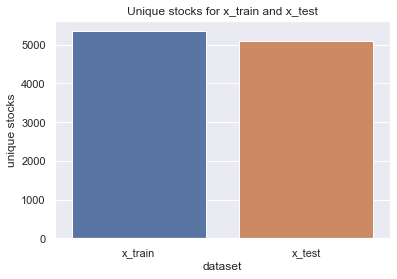

There is 367 new stocks in the test dataset which represents 6.86% of the stocks present in x_train.


In [103]:
data = pd.DataFrame(data=[[len(x_train.STOCK.unique()), 'x_train'],
                          [len(x_test.STOCK.unique()), 'x_test']],
                    columns=['unique stocks', 'dataset'])
sns.barplot(x='dataset', y='unique stocks', data=data)
plt.title("Unique stocks for x_train and x_test")
plt.show()

### compute the number of new stocks in the test dataset
unique_stock_train = x_train.STOCK.unique()
is_test_stock_in_train = [stock in unique_stock_train for stock in x_test.STOCK.unique()]
new_stock_test = len(is_test_stock_in_train) - sum(is_test_stock_in_train)
print("There is %d new stocks in the test dataset which represents %.2f%% of the stocks present in x_train."
      %(new_stock_test, (new_stock_test / len(x_train.STOCK.unique())) * 100))

On remarque qu'il y a des nouveaux stocks dans l'échantillon test mais cela reste raisonnable.

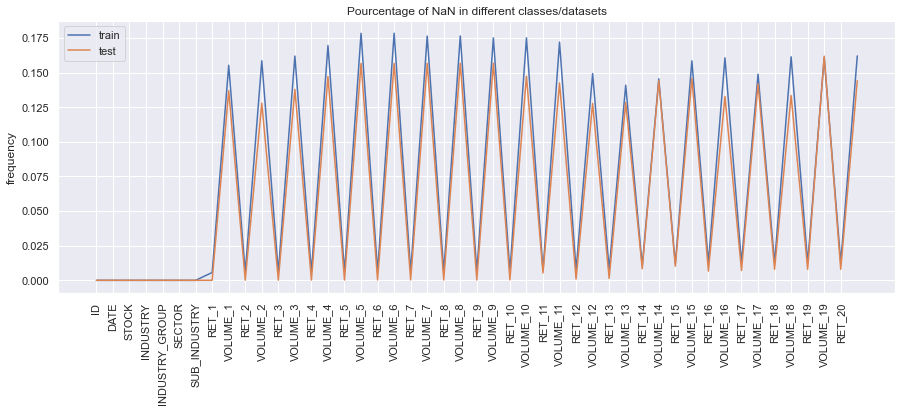

In [104]:
plt.figure(figsize=(15, 5))
(x_train.isna().sum() / len(x_train)).plot(label='train', use_index=False)
(x_test.isna().sum() / len(x_test)).plot(label='test', use_index=False)
plt.xticks(np.arange(46), x_train.columns, rotation=90)
plt.ylabel('frequency')
plt.title("Pourcentage of NaN in different classes/datasets")
plt.legend()
plt.show()

On remarque que les valeurs manquantes sont surtout au niveau des features 'Volume' dans les deux échantillons.

# Feature Engineering

On va maintenant ajouter des variables qui peuvent améliorer l'analyse des données. Ces variables introduites viennent notamment de <html> https://www.sciencedirect.com/science/article/pii/S2405844019359705 qui est une étude sur les return de stocks en utilisant les forêts aléatoires.

In [105]:
dic = {}
for week in range(2):
    features = []
    for day in range(1, 6):
        features.append('RET_' + str(week * 5 + day))
    dic['AVG_RET_' + str(week + 1)] = x_train[features].mean(axis=1)
technical_features = pd.DataFrame(dic)
pd.DataFrame(dic).head()

,AVG_RET_1,AVG_RET_2
0,-0.003694,0.059023
1,-0.026274,0.038943
2,-0.006658,0.010191
3,0.003658,-0.011622
4,0.002059,-0.002470


In [106]:
dic = {}
for week in range(2):
    features = []
    for day in range(1, 6):
        features.append('RET_' + str(week * 5 + day))
    dic['AVG_RET_' + str(week + 1)] = x_test[features].mean(axis=1)
technical_features1 = pd.DataFrame(dic)
pd.DataFrame(dic).head()

,AVG_RET_1,AVG_RET_2
0,0.007166,-0.000524
1,-0.002511,0.006814
2,-0.015665,0.005714
3,0.004168,0.010717
4,-0.001829,0.007099


### Refers to a rate of acceleration of a stock’s volume and can be used to help identify trend lines of volume

In [107]:
dic = {}
features = []
for week in range(4):
    for day in range(1, 6):
        features.append('VOLUME_' + str(week * 5 + day))
    dic['VOL_' + str(week + 1)] = x_train[features].mean(axis=1)
res = {}
res['VOL_1/VOL_2'] = dic['VOL_1'] / dic['VOL_2']
res['VOL_1/VOL_3'] = dic['VOL_1'] / dic['VOL_3']
res['VOL_1/VOL_4'] = dic['VOL_1'] / dic['VOL_4']
technical_features = pd.concat((technical_features, pd.DataFrame(res)), axis=1)
pd.DataFrame(res).head()

,VOL_1/VOL_2,VOL_1/VOL_3,VOL_1/VOL_4
0,-0.154314,-0.331097,-0.426286
1,NaN,NaN,NaN
2,0.482402,0.426954,0.358949
3,1.399066,1.034698,1.106327
4,1.266714,-1.510818,-1.810634


In [108]:
dic = {}
features = []
for week in range(4):
    for day in range(1, 6):
        features.append('VOLUME_' + str(week * 5 + day))
    dic['VOL_' + str(week + 1)] = x_test[features].mean(axis=1)
res = {}
res['VOL_1/VOL_2'] = dic['VOL_1'] / dic['VOL_2']
res['VOL_1/VOL_3'] = dic['VOL_1'] / dic['VOL_3']
res['VOL_1/VOL_4'] = dic['VOL_1'] / dic['VOL_4']
technical_features1 = pd.concat((technical_features1, pd.DataFrame(res)), axis=1)
pd.DataFrame(res).head()

,VOL_1/VOL_2,VOL_1/VOL_3,VOL_1/VOL_4
0,-0.005655,-0.002912,-0.002834
1,1.190858,1.796281,1.799375
2,1.545200,2.237034,4.419036
3,-0.595983,0.075749,0.112910
4,0.664994,0.617317,0.816838


### Refers to the volatility over the past m trading days as calculated by the standard deviation of daily returns

In [109]:
dic = {}
features = []
for week in range(4):
    for day in range(1, 6):
        features.append('RET_' + str(week * 5 + day))
    dic['STD_RET_' + str(week + 1)] = x_train[features].std(axis=1)
technical_features = pd.concat((technical_features, pd.DataFrame(dic)), axis=1)
pd.DataFrame(dic).head()

,STD_RET_1,STD_RET_2,STD_RET_3,STD_RET_4
0,0.016027,0.071108,0.061764,0.054646
1,0.042498,0.065736,0.055483,0.048808
2,0.031757,0.031049,0.026459,0.023417
3,0.018668,0.020922,0.018406,0.020831
4,0.026294,0.022812,0.034238,0.032045


In [110]:
dic = {}
features = []
for week in range(4):
    for day in range(1, 6):
        features.append('RET_' + str(week * 5 + day))
    dic['STD_RET_' + str(week + 1)] = x_test[features].std(axis=1)
technical_features1 = pd.concat((technical_features1, pd.DataFrame(dic)), axis=1)
pd.DataFrame(dic).head()

,STD_RET_1,STD_RET_2,STD_RET_3,STD_RET_4
0,0.008115,0.007013,0.007393,0.008588
1,0.017657,0.015781,0.018529,0.016163
2,0.039618,0.030868,0.024874,0.021897
3,0.011082,0.011144,0.011197,0.013121
4,0.028448,0.021256,0.018942,0.017663


### Refers to the standard deviation of trading volume time series over the past m trading days

In [111]:
dic = {}
features = []
for week in range(4):
    for day in range(1, 6):
        features.append('VOLUME_' + str(week * 5 + day))
    dic['STD_VOL_' + str(week + 1)] = x_train[features].std(axis=1)
technical_features = pd.concat((technical_features, pd.DataFrame(dic)), axis=1)
pd.DataFrame(dic).head()

,STD_VOL_1,STD_VOL_2,STD_VOL_3,STD_VOL_4
0,0.485623,2.816734,2.497299,2.163249
1,NaN,NaN,NaN,NaN
2,0.166250,0.342035,0.283777,0.264779
3,0.348658,0.459691,0.579454,0.518702
4,0.194741,0.390729,5.062285,4.355388


In [112]:
dic = {}
features = []
for week in range(4):
    for day in range(1, 6):
        features.append('VOLUME_' + str(week * 5 + day))
    dic['STD_VOL_' + str(week + 1)] = x_test[features].std(axis=1)
technical_features1 = pd.concat((technical_features1, pd.DataFrame(dic)), axis=1)
pd.DataFrame(dic).head()

,STD_VOL_1,STD_VOL_2,STD_VOL_3,STD_VOL_4
0,0.275660,0.211623,0.242260,0.224124
1,0.306683,0.411666,0.673296,0.610103
2,1.158301,0.824059,0.709316,0.676794
3,0.178058,0.552054,0.521546,0.490266
4,0.118051,0.236249,0.227985,0.408393


### Utilisation des dates et secteurs

Nous allons maintenant créer une variable pour prendre en compte le secteur. Nous voulons comparer le volume d'une action à une date donée avec la somme des volumes des autres actions d'entreprise du même secteur et à la même date.

In [113]:
dic = {}
features = []
for week in range(4):
    for day in range(1, 6):
        features.append('VOLUME_' + str(week * 5 + day))
    dic['VOL_' + str(week + 1)] = x_train[features].mean(axis=1).abs()
pd.DataFrame(dic).head()

,VOL_1,VOL_2,VOL_3,VOL_4
0,0.194968,1.263455,0.588855,0.457365
1,NaN,NaN,NaN,NaN
2,0.075251,0.155992,0.176250,0.209642
3,0.596365,0.426259,0.576366,0.539049
4,1.097822,0.866669,0.726641,0.606319


In [114]:
df = pd.concat((x_train, pd.DataFrame(dic)), axis=1)
rt = pd.DataFrame()
rt['PER_VOL_1'] = df['VOL_1'] / df.groupby(['SECTOR', 'DATE'])['VOL_1'].transform('sum')
rt['PER_VOL_2'] = df['VOL_2'] / df.groupby(['SECTOR', 'DATE'])['VOL_2'].transform('sum')
rt['PER_VOL_3'] = df['VOL_3'] / df.groupby(['SECTOR', 'DATE'])['VOL_3'].transform('sum')
rt['PER_VOL_4'] = df['VOL_4'] / df.groupby(['SECTOR', 'DATE'])['VOL_4'].transform('sum')

In [115]:
technical_features = pd.concat((rt, technical_features), axis=1)

In [116]:
technical_features['COND_AVG_RET_1'] = x_train.groupby(['SECTOR', 'DATE'])['RET_1'].transform('mean')
technical_features['COND_AVG_RET_2'] = x_train.groupby(['SECTOR', 'DATE'])['RET_2'].transform('mean')
technical_features['COND_AVG_VOL_1'] = x_train.groupby(['SECTOR', 'DATE'])['VOLUME_1'].transform('mean')

In [117]:
dic = {}
features = []
for week in range(4):
    for day in range(1, 6):
        features.append('VOLUME_' + str(week * 5 + day))
    dic['VOL_' + str(week + 1)] = x_test[features].mean(axis=1).abs()
pd.DataFrame(dic).head()

,VOL_1,VOL_2,VOL_3,VOL_4
0,0.000468,0.082711,0.160619,0.165027
1,0.614358,0.515895,0.342017,0.341429
2,0.707427,0.457822,0.316234,0.160086
3,0.011577,0.019425,0.152835,0.102533
4,0.288493,0.433828,0.467333,0.353182


In [118]:
df = pd.concat((x_train, pd.DataFrame(dic)), axis=1)
rt = pd.DataFrame()
rt['PER_VOL_1'] = df['VOL_1'] / df.groupby(['SECTOR', 'DATE'])['VOL_1'].transform('sum')
rt['PER_VOL_2'] = df['VOL_2'] / df.groupby(['SECTOR', 'DATE'])['VOL_2'].transform('sum')
rt['PER_VOL_3'] = df['VOL_3'] / df.groupby(['SECTOR', 'DATE'])['VOL_3'].transform('sum')
rt['PER_VOL_4'] = df['VOL_4'] / df.groupby(['SECTOR', 'DATE'])['VOL_4'].transform('sum')

In [119]:
technical_features1 = pd.concat((rt, technical_features1), axis=1)

In [120]:
technical_features1['COND_AVG_RET_1'] = x_test.groupby(['SECTOR', 'DATE'])['RET_1'].transform('mean')
technical_features1['COND_AVG_RET_2'] = x_test.groupby(['SECTOR', 'DATE'])['RET_2'].transform('mean')
technical_features1['COND_AVG_VOL_1'] = x_test.groupby(['SECTOR', 'DATE'])['VOLUME_1'].transform('mean')

### Real return

In [121]:
## real return sqrt(prod_1_n 1 + r_i/100, n) (geometric mean)
X = np.ones(len(x_train))
for col in ['RET_' + str(i) for i in range(1, 3)]:
    X *= 1 + x_train[col] / 100 
technical_features['REAL_RET'] = X ** (1 / 2)

In [122]:
## real return sqrt(prod_1_n 1 + r_i/100, n)(geometric mean)
X = np.ones(len(x_test))
for col in ['RET_' + str(i) for i in range(1, 3)]:
    X *= 1 + x_test[col] / 100 
technical_features1['REAL_RET'] = X ** (1 / 2)

### Non sytematic risk

In [123]:
mean_1 = x_train.groupby(['SECTOR', 'DATE'])['RET_1'].transform('mean')
mean_2 = x_train.groupby(['SECTOR', 'DATE'])['RET_2'].transform('mean')
technical_features['NON_SYS_RISK'] = np.sqrt((x_train['RET_1'] - mean_1) ** 2 + (x_train['RET_2'] - mean_2) ** 2)

In [124]:
mean_1 = x_test.groupby(['SECTOR', 'DATE'])['RET_1'].transform('mean')
mean_2 = x_test.groupby(['SECTOR', 'DATE'])['RET_2'].transform('mean')
technical_features1['NON_SYS_RISK'] = np.sqrt((x_test['RET_1'] - mean_1) ** 2 + (x_test['RET_2'] - mean_2) ** 2)

In [125]:
technical_features1

,PER_VOL_1,PER_VOL_2,PER_VOL_3,PER_VOL_4,AVG_RET_1,AVG_RET_2,VOL_1/VOL_2,VOL_1/VOL_3,VOL_1/VOL_4,STD_RET_1,...,STD_RET_4,STD_VOL_1,STD_VOL_2,STD_VOL_3,STD_VOL_4,COND_AVG_RET_1,COND_AVG_RET_2,COND_AVG_VOL_1,REAL_RET,NON_SYS_RISK
0,0.000003,0.000560,0.001213,0.001389,0.007166,-0.000524,-0.005655,-0.002912,-0.002834,0.008115,...,0.008588,0.275660,0.211623,0.242260,0.224124,0.003720,0.007990,0.077369,1.000151,0.016617
1,0.004885,0.003425,0.002687,0.003294,-0.002511,0.006814,1.190858,1.796281,1.799375,0.017657,...,0.016163,0.306683,0.411666,0.673296,0.610103,0.003339,0.015663,-0.098914,1.000155,0.008522
2,0.003781,0.002500,0.001969,0.001129,-0.015665,0.005714,1.545200,2.237034,4.419036,0.039618,...,0.021897,1.158301,0.824059,0.709316,0.676794,-0.000866,0.017638,-0.159531,1.000055,0.013113
3,0.000316,0.000503,0.003477,0.002786,0.004168,0.010717,-0.595983,0.075749,0.112910,0.011082,...,0.013121,0.178058,0.552054,0.521546,0.490266,0.003720,0.007990,0.077369,1.000008,0.024654
4,0.008208,0.012715,0.015898,0.013201,-0.001829,0.007099,0.664994,0.617317,0.816838,0.028448,...,0.017663,0.118051,0.236249,0.227985,0.408393,-0.000866,0.017638,-0.159531,1.000171,0.013328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
418591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
418592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
418593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Feature selection

In [126]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

In [127]:
estimator = RandomForestClassifier(n_estimators=60, max_depth=2 ** 3, random_state=0, n_jobs=-1, verbose = 10)
selector = RFE(estimator, 5, step=1)
selector = selector.fit(technical_features.fillna(0), y_train['RET'])

/Users/Bilel945/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 60
building tree 2 of 60
building tree 3 of 60
building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.0s


building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.1s


building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.8s


building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   15.1s


building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   22.2s


building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.0s


building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   36.3s


building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   39.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   39.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 60
building tree 2 of 60building tree 3 of 60
building tree 4 of 60

building tree 5 of 60building tree 6 of 60

building tree 7 of 60
building tree 8 of 60


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.9s


building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.9s


building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.0s


building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   14.7s


building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.5s


building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.2s


building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   31.4s


building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   34.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   34.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 60building tree 2 of 60building tree 3 of 60
building tree 4 of 60


building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.3s


building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.4s


building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.7s


building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   13.2s


building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.7s


building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.2s


building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.6s


building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   33.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   33.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 60building tree 2 of 60building tree 3 of 60
building tree 4 of 60


building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.3s


building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.5s


building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.7s


building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   13.4s


building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.3s


building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.7s


building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.2s


building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   33.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   33.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 60building tree 2 of 60building tree 3 of 60

building tree 4 of 60

building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.2s


building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.2s


building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.0s


building tree 21 of 60
building tree 22 of 60
building tree 23 of 60building tree 24 of 60

building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   15.8s


building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.8s


building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60
building tree 47 of 60


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.3s


building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   32.4s


building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   35.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   35.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 60building tree 2 of 60
building tree 3 of 60

building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.2s


building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.4s


building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.7s


building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60building tree 26 of 60

building tree 27 of 60


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   13.3s


building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.4s


building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60
building tree 47 of 60
building tree 48 of 60


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.9s


building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.2s


building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   32.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   32.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 60building tree 2 of 60building tree 3 of 60

building tree 4 of 60

building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.3s


building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.6s


building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.7s


building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   13.2s


building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.3s


building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.8s


building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.1s


building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   32.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   32.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 60
building tree 2 of 60building tree 3 of 60
building tree 4 of 60

building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.3s


building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.1s


building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.4s


building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   10.5s


building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.2s


building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.8s


building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   23.9s


building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   25.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   25.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 60building tree 2 of 60

building tree 3 of 60building tree 4 of 60

building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.3s


building tree 9 of 60building tree 10 of 60

building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.9s


building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.6s


building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   10.5s


building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.1s


building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.9s


building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   23.8s


building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   25.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   25.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 60
building tree 2 of 60building tree 3 of 60

building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.5s


building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60building tree 15 of 60

building tree 16 of 60


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.1s


building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.0s


building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   10.1s


building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.7s


building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.9s


building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   22.8s


building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   24.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   24.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 60
building tree 2 of 60building tree 3 of 60
building tree 4 of 60

building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.1s


building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.7s


building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.9s


building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.9s


building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.4s


building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60
building tree 47 of 60


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.8s


building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   22.4s


building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   24.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   24.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 60building tree 2 of 60building tree 3 of 60
building tree 4 of 60


building tree 5 of 60building tree 6 of 60

building tree 7 of 60
building tree 8 of 60


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.1s


building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.7s


building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.6s


building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   10.3s


building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.1s


building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.6s


building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   23.3s


building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   25.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   25.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 60
building tree 2 of 60building tree 3 of 60
building tree 4 of 60

building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.8s


building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.5s


building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.4s


building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   20.1s


building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   28.6s


building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.5s


building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   44.7s


building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   49.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   49.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 60building tree 2 of 60
building tree 3 of 60
building tree 4 of 60

building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.0s


building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.3s


building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   15.0s


building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   19.0s


building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   28.9s


building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.3s


building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   47.0s


building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   49.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   49.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 60
building tree 2 of 60
building tree 3 of 60building tree 4 of 60

building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.6s


building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s


building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.2s


building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.6s


building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.9s


building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.5s


building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.7s


building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   18.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   18.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 60building tree 2 of 60
building tree 3 of 60

building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.6s


building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s


building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.1s


building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.5s


building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.5s


building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.8s


building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.0s


building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   17.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   17.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 60
building tree 2 of 60building tree 3 of 60
building tree 4 of 60

building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s


building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.1s


building tree 14 of 60
building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.9s


building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.5s


building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.1s


building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.3s


building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   14.4s


building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   16.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   16.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 60
building tree 2 of 60
building tree 3 of 60building tree 4 of 60

building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s


building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s


building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.7s


building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.1s


building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.4s


building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.5s


building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.0s


building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   14.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   14.3s finished


# Modèle

In [128]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [129]:
selector.ranking_

array([15,  7, 12,  8,  2,  6, 17, 18, 16,  4,  3,  1,  1, 10, 14,  9, 13,
        1,  1,  1,  5, 11])

Il s'agit ici de régler les hyperparamètres pour avoir la meilleure classification. On essaye plusieurs méthodes, mais celle qui semble le plus efficace d'un point de vue computationnel et classification est la forêt aléatoire.

In [132]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [88]:
X_train = technical_features
Y_train = y_train['RET']

## only select not na
X_train = technical_features.dropna()
idx = X_train.index
Y_train = y_train.loc[idx]['RET']
X_test = technical_features1.dropna()

# A quiet large number of trees with low depth to prevent overfits
rf_params = {
     'n_estimators':70,
     'max_depth': 8,
     'random_state': 0,
     'n_jobs': -1,
     'max_features':18 
}

xg_params = {
    'n_estimators' : 160,
    'learning_rate' : 0.01,
    'max_depth' : 8,
    'n_jobs' : -1,
    'random_state' : 0,
    
}

svm_params = {
    'C' : 0.75,
    'gamma' : 0.015,
    'kernel' : 'rbf',
    'probability' : True,
    'decision_function_shape' : 'ovo',
    'verbose' : 10
    
}

train_dates = x_train['DATE'].unique()
test_dates = x_test['DATE'].unique()

n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = x_train['DATE'].isin(local_train_dates)
    local_test_ids = x_train['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = Y_train.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = Y_train.loc[local_test_ids]

    X_local_train = X_local_train.fillna(0)
    X_local_test = X_local_test.fillna(0)

    model = RandomForestClassifier(**rf_params)
    model.fit(X_local_train, y_local_train)

    y_local_pred = model.predict_proba(X_local_test)[:, 1]
    
    sub = X_train.loc[local_test_ids].copy()
    sub['DATE'] = x_train.loc[sub.index]['DATE']
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.mean()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores) * 100
std = np.std(scores) * 100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Accuracy: 52.30%
Fold 2 - Accuracy: 49.33%
Fold 3 - Accuracy: 50.14%
Fold 4 - Accuracy: 50.56%
Accuracy: 50.58% [49.49 ; 51.67] (+- 1.09)


In [133]:
train_dates = x_train['DATE'].unique()
test_dates = x_test['DATE'].unique()

In [134]:
train = x_train['DATE'].isin(train_dates)
test = x_test['DATE'].isin(test_dates)

In [135]:
idx = technical_features.dropna().index

In [ ]:
print(technical_features.columns, technical_features1.columns)


In [136]:
model = RandomForestClassifier(**rf_params)
model.fit(technical_features.fillna(0), y_train['RET'])
ypred1 = model.predict_proba(technical_features1.fillna(0))[:, 1]

In [139]:
sub = technical_features1.fillna(0).copy()
sub['DATE'] = x_test.loc[sub.index]['DATE']
sub['pred'] = ypred1
ypred1 = sub.groupby('DATE')['pred'].transform(lambda x: x > x.mean()).values

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [ ]:
feature_importances = pd.DataFrame([model.feature_importances_ for model in models],
                                   columns=technical_features.columns)

sns.barplot(data=feature_importances, orient='h',
            order=feature_importances.mean().sort_values(ascending=False).index)
plt.show()